In [22]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
df = pd.read_excel('dataset\Dataset Text.xlsx')

In [24]:
df.head()

,Kalimat,Label,Text
0,R1,supports,competition can effectively promote the develo...
1,R2,attacks,competition can effectively promote the develo...
2,R3,supports,what we acquired from team work is not only ho...
3,R4,supports,through cooperation children can learn about i...
4,R5,supports,all of these skills help them to get on well w...


In [25]:
df = df.drop(['Kalimat'],axis=1)

In [26]:
df.head()

,Label,Text
0,supports,competition can effectively promote the develo...
1,attacks,competition can effectively promote the develo...
2,supports,what we acquired from team work is not only ho...
3,supports,through cooperation children can learn about i...
4,supports,all of these skills help them to get on well w...


Text(0.5, 1.0, 'Label Data Distribution')

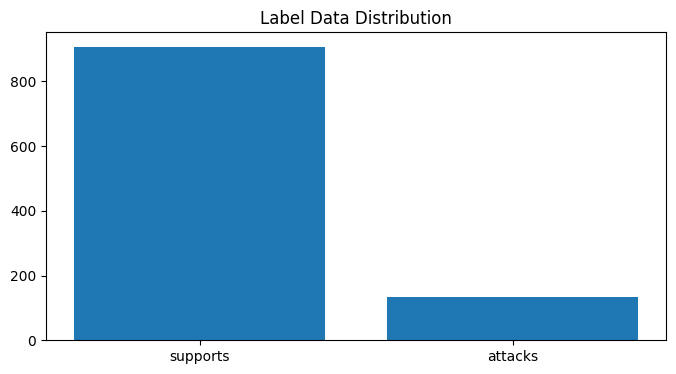

In [27]:
val_count = df.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title('Label Data Distribution')

Tokenizer

In [28]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Text'].values)
x = tokenizer.texts_to_sequences(df['Text'].values)
x = pad_sequences(x)

In [29]:
le = LabelEncoder()
y = le.fit_transform(df['Label'].values)
y = y.reshape(-1,1)

Balancing

In [30]:
from imblearn.over_sampling import SMOTEN, SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter

In [31]:
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5, n_jobs=4)
x_smote, y_smote = smote.fit_resample(x, y)

In [32]:
print(f'After OverSampling: {Counter(y_smote)}')

After OverSampling: Counter({1: 906, 0: 906})


In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

# LSTM Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'].values)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [36]:
input_features = x_train.shape[1]

In [37]:
embed_dim = 128     #128
lstm_out = 196

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim,input_length = input_features))
model.add(SpatialDropout1D(0.9))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 71, 128)           390144    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 71, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 645,338
Trainable params: 645,338
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
batch_size = 64
history = model.fit(x_train, y_train, epochs = 10, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/10
23/23 [==============================] - 16s 505ms/step - loss: 0.6873 - accuracy: 0.5314 - val_loss: 0.6688 - val_accuracy: 0.6198
Epoch 2/10
23/23 [==============================] - 13s 585ms/step - loss: 0.6546 - accuracy: 0.6315 - val_loss: 0.6134 - val_accuracy: 0.7163
Epoch 3/10
23/23 [==============================] - 13s 584ms/step - loss: 0.5996 - accuracy: 0.6922 - val_loss: 0.5749 - val_accuracy: 0.7521
Epoch 4/10
23/23 [==============================] - 16s 712ms/step - loss: 0.5549 - accuracy: 0.7398 - val_loss: 0.5202 - val_accuracy: 0.7686
Epoch 5/10
23/23 [==============================] - 16s 716ms/step - loss: 0.5161 - accuracy: 0.7405 - val_loss: 0.4959 - val_accuracy: 0.7438
Epoch 6/10
23/23 [==============================] - 14s 602ms/step - loss: 0.4850 - accuracy: 0.7833 - val_loss: 0.4850 - val_accuracy: 0.7410
Epoch 7/10
23/23 [==============================] - 15s 645ms/step - loss: 0.4136 - accuracy: 0.8150 - val_loss: 0.4956 - val_accuracy: 0.7438

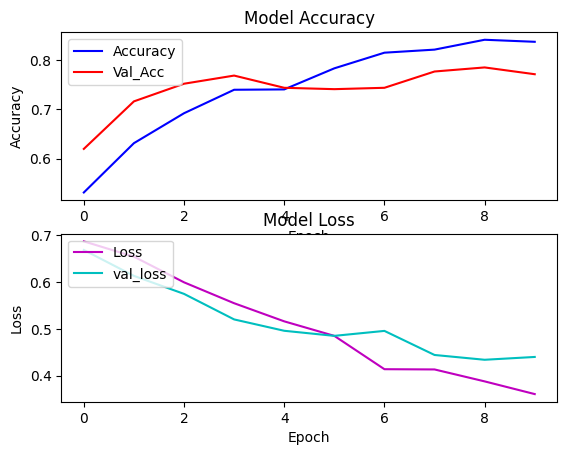

In [39]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Accuracy', 'Val_Acc'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Loss', 'val_loss'], loc = 'upper left')

In [40]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 1s 40ms/step - loss: 0.4398 - accuracy: 0.7713


[0.43984904885292053, 0.7713498473167419]

In [41]:
lstm_predict = model.predict(x_test)

12/12 [==============================] - 1s 49ms/step


In [42]:
print(classification_report(y_test, lstm_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       188
           1       0.77      0.75      0.76       175

    accuracy                           0.77       363
   macro avg       0.77      0.77      0.77       363
weighted avg       0.77      0.77      0.77       363

